In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.9 MB/s eta 0:00:00


### **Libraries**

In [2]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from skimage.measure import regionprops
from skimage.segmentation import slic
from skimage import graph as skgraph
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import cv2
import os

### **Feature extration for image regions**

In [ ]:
def extract_region_features(img_rgb, img_gray, segments):
    regions = regionprops(segments + 1, intensity_image=img_gray)
    node_features = []
    
    for region in regions:
        region_mask = segments == region.label - 1
        
        # 5 intensity features (from grayscale)
        region_gray = img_gray[region_mask]
        mean_intensity = np.mean(region_gray)
        std_intensity = np.std(region_gray)
        min_intensity = np.min(region_gray)
        max_intensity = np.max(region_gray)
        median_intensity = np.median(region_gray)
        
        # 6 color features (from RGB)
        region_rgb = img_rgb[region_mask]
        mean_r = np.mean(region_rgb[:, 0])
        mean_g = np.mean(region_rgb[:, 1])
        mean_b = np.mean(region_rgb[:, 2])
        std_r = np.std(region_rgb[:, 0])
        std_g = np.std(region_rgb[:, 1])
        std_b = np.std(region_rgb[:, 2])
        
        # 5 texture features (GLCM - Gray Level Co-occurrence Matrix)
        try:
            minr, minc, maxr, maxc = region.bbox
            roi = img_gray[minr:maxr, minc:maxc]
            roi_norm = ((roi - roi.min()) / (roi.max() - roi.min() + 1e-8) * 255).astype(np.uint8)
            
            glcm = graycomatrix(roi_norm, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
            
            contrast = graycoprops(glcm, 'contrast').mean()
            dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
            homogeneity = graycoprops(glcm, 'homogeneity').mean()
            energy = graycoprops(glcm, 'energy').mean()
            correlation = graycoprops(glcm, 'correlation').mean()
        except:
            contrast = dissimilarity = homogeneity = energy = correlation = 0.0
        
        # 9 shape features
        area = region.area
        perimeter = region.perimeter if region.perimeter > 0 else 1.0
        eccentricity = region.eccentricity
        solidity = region.solidity
        extent = region.extent
        compactness = (4 * np.pi * area) / (perimeter ** 2)
        major_axis = region.major_axis_length if region.major_axis_length > 0 else 1.0
        minor_axis = region.minor_axis_length if region.minor_axis_length > 0 else 1.0
        aspect_ratio = major_axis / minor_axis
        
        # Combine all 25 features
        features = [
            mean_intensity, std_intensity, min_intensity, max_intensity, median_intensity,
            mean_r, mean_g, mean_b, std_r, std_g, std_b,
            contrast, dissimilarity, homogeneity, energy, correlation,
            area, perimeter, eccentricity, solidity, extent,
            compactness, aspect_ratio, major_axis, minor_axis
        ]
        
        node_features.append(features)
    
    return np.array(node_features, dtype=np.float32)

In [ ]:
def image_to_graph(img_path, img_size=224, n_segments=80):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Cannot read {img_path}")
    
    if len(img.shape) == 2:
        img = gray2rgb(img)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = cv2.resize(img, (img_size, img_size))
    img_rgb = img.astype(np.float32) / 255.0
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # SLIC segmentation: divide image into superpixels
    segments = slic(img_rgb, n_segments=n_segments, compactness=10, igma=1, start_label=0, channel_axis=-1)
    
    # extract features for each superpixel
    node_features = extract_region_features(img_rgb, img_gray, segments)
    
    # normalize features
    node_features = (node_features - node_features.mean(axis=0)) / (node_features.std(axis=0) + 1e-8)
    
    # Build Region Adjacency Graph (RAG) with connecting superpixels that share boundaries
    rag = skgraph.rag_mean_color(img_rgb, segments)
    
    edges = []
    for n1, n2 in rag.edges():
        edges.append([n1, n2])
        edges.append([n2, n1])  # bidirectional
    
    if len(edges) == 0:
        for i in range(len(node_features) - 1):
            edges.append([i, i + 1])
            edges.append([i + 1, i])
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = torch.tensor(node_features, dtype=torch.float)
    
    # validate edges
    num_nodes = x.size(0)
    valid_edges = (edge_index[0] < num_nodes) & (edge_index[1] < num_nodes)
    edge_index = edge_index[:, valid_edges]
    
    return Data(x=x, edge_index=edge_index), segments, img_rgb

### **GAT Model**

In [ ]:
class BrainTumorGAT(nn.Module):
    def __init__(self, in_channels=25, hidden_channels=128, num_classes=4, num_heads=6, num_layers=3, dropout=0.35):
        super(BrainTumorGAT, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        # input layer
        self.conv_in = GATConv(in_channels, hidden_channels, heads=num_heads, dropout=dropout, concat=True)
        self.bn_in = nn.BatchNorm1d(hidden_channels * num_heads)
        
        # hidden layers
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        
        for _ in range(num_layers - 2):
            self.convs.append(
                GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=dropout, concat=True)
            )
            self.bns.append(nn.BatchNorm1d(hidden_channels * num_heads))
        
        # output layer
        self.conv_out = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, dropout=dropout, concat=False)
        self.bn_out = nn.BatchNorm1d(hidden_channels)
        
        # classification head
        pooled_dim = hidden_channels * 2
        self.fc1 = nn.Linear(pooled_dim, hidden_channels)
        self.bn_fc = nn.BatchNorm1d(hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, num_classes)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = data.batch if hasattr(data, 'batch') else \
                torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        
        # gat layers
        x = self.conv_in(x, edge_index)
        x = self.bn_in(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv_out(x, edge_index)
        x = self.bn_out(x)
        x = F.elu(x)
        
        # global pooling: aggregate all nodes into graph representation
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        x = torch.cat([x_mean, x_max], dim=1)
        
        # classification
        x = self.fc1(x)
        x = self.bn_fc(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

### **Data Loading**

In [ ]:
def prepare_dataset(data_dir, img_size=224, n_segments=80, max_samples_per_class=None):
    graphs = []
    labels = []
    label_map = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
    
    for class_name, label in label_map.items():
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} not found, skipping...")
            continue
        
        img_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        if max_samples_per_class:
            img_files = img_files[:max_samples_per_class]
        
        print(f"Processing {class_name} ({len(img_files)} images)...")
        for img_file in tqdm(img_files):
            img_path = os.path.join(class_dir, img_file)
            try:
                graph_data, _, _ = image_to_graph(img_path, img_size, n_segments)
                graph_data.y = torch.tensor([label], dtype=torch.long)
                graphs.append(graph_data)
                labels.append(label)
            except Exception as e:
                print(f"Error: {img_path}: {e}")
    
    return graphs, labels

### **Training and Evaluation**

In [ ]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)
    
    return total_loss / len(loader), correct / total

def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
    
    return accuracy_score(all_labels, all_preds), all_preds, all_labels

### **Visualization Functions**

In [ ]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # loss plot
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss Over Time')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # accuracy plot
    axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
    axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy Over Time')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: training_history.png")

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: confusion_matrix.png")

In [ ]:
def visualize_graph_construction(img_path, n_segments=80):
    graph_data, segments, img_rgb = image_to_graph(img_path, n_segments=n_segments)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # original image
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original Image', fontsize=14)
    axes[0].axis('off')
    
    # superpixel segmentation
    axes[1].imshow(segments, cmap='nipy_spectral')
    axes[1].set_title(f'SLIC Segmentation ({segments.max()+1} regions)', fontsize=14)
    axes[1].axis('off')
    
    # graph structure info
    num_nodes = graph_data.x.size(0)
    num_edges = graph_data.edge_index.size(1)
    num_features = graph_data.x.size(1)
    
    info_text = f"""
    Graph Structure:
    
    Nodes: {num_nodes}
    Edges: {num_edges}
    Features per node: {num_features}
    
    Node features include:
    • Intensity statistics (5)
    • Color statistics (6)
    • Texture features (5)
    • Shape features (9)
    
    Edges connect adjacent
    superpixel regions
    """
    
    axes[2].text(0.1, 0.5, info_text, fontsize=12, verticalalignment='center', family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[2].axis('off')
    axes[2].set_title('Graph Information', fontsize=14)
    
    plt.tight_layout()
    plt.savefig('graph_construction.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: graph_construction.png")

### **Configuration**

In [11]:
DATA_DIR = '/kaggle/input/brain-tumor-mri-dataset/Training'
TEST_DIR = '/kaggle/input/brain-tumor-mri-dataset/Testing'

IMG_SIZE = 224
N_SEGMENTS = 80
BATCH_SIZE = 16
HIDDEN_CHANNELS = 128
NUM_HEADS = 6
NUM_LAYERS = 3
DROPOUT = 0.35
LEARNING_RATE = 0.001
EPOCHS = 300

In [12]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {DEVICE}")


Device: cuda


### **Visualizing Graph Construction**

Sample image: /kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-gl_0954.jpg


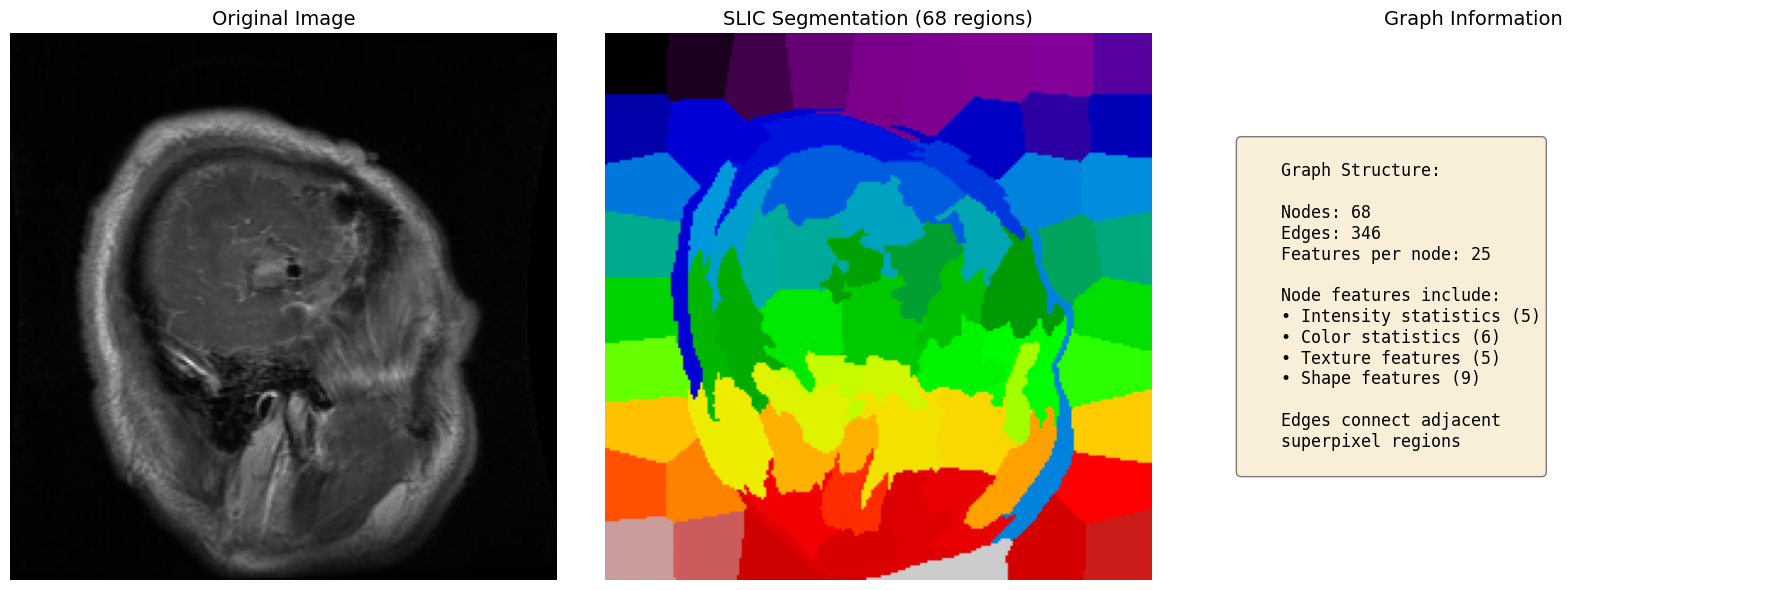

Saved: graph_construction.png


In [13]:
sample_img = None
for class_name in ['glioma', 'meningioma', 'notumor', 'pituitary']:
    class_dir = os.path.join(DATA_DIR, class_name)
    if os.path.exists(class_dir):
        img_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]
        if img_files:
            sample_img = os.path.join(class_dir, img_files[0])
            break
    
if sample_img:
    print(f"Sample image: {sample_img}")
    visualize_graph_construction(sample_img, n_segments=N_SEGMENTS)

### **Load Dataset**

In [14]:
print("training data:")
train_graphs, train_labels = prepare_dataset( DATA_DIR, IMG_SIZE, N_SEGMENTS )

training data:
Processing glioma (1321 images)...


100%|██████████| 1321/1321 [53:55<00:00,  2.45s/it]


Processing meningioma (1339 images)...


100%|██████████| 1339/1339 [54:31<00:00,  2.44s/it]


Processing notumor (1595 images)...


100%|██████████| 1595/1595 [57:26<00:00,  2.16s/it]


Processing pituitary (1457 images)...


100%|██████████| 1457/1457 [1:00:52<00:00,  2.51s/it]


In [15]:
print("test data:")
test_graphs, test_labels = prepare_dataset( TEST_DIR, IMG_SIZE, N_SEGMENTS )

test data:
Processing glioma (300 images)...


100%|██████████| 300/300 [12:35<00:00,  2.52s/it]


Processing meningioma (306 images)...


100%|██████████| 306/306 [13:43<00:00,  2.69s/it]


Processing notumor (405 images)...


100%|██████████| 405/405 [18:11<00:00,  2.70s/it]


Processing pituitary (300 images)...


100%|██████████| 300/300 [14:55<00:00,  2.98s/it]


In [ ]:
# split training into train/val
train_graphs, val_graphs = train_test_split( train_graphs, test_size=0.2, random_state=42, stratify=train_labels )

In [17]:
print(f"dataset sizes:")
print(f"training: {len(train_graphs)} graphs")
print(f"validation: {len(val_graphs)} graphs")
print(f"test: {len(test_graphs)} graphs")

dataset sizes:
training: 4569 graphs
validation: 1143 graphs
test: 1311 graphs


In [18]:
# create data loaders
train_loader = DataLoader(train_graphs, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_graphs, batch_size=BATCH_SIZE)

/tmp/ipykernel_24/2672411747.py:2: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_graphs, batch_size=BATCH_SIZE, shuffle=True)
/tmp/ipykernel_24/2672411747.py:3: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(val_graphs, batch_size=BATCH_SIZE)
/tmp/ipykernel_24/2672411747.py:4: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_graphs, batch_size=BATCH_SIZE)


In [19]:
model = BrainTumorGAT(
    in_channels=25,
    hidden_channels=HIDDEN_CHANNELS,
    num_classes=4,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

In [20]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [21]:
print(f"total parameters: {total_params:,}")
print(f"trainable parameters: {trainable_params:,}")

total parameters: 749,316
trainable parameters: 749,316


In [22]:
print(f"\model arch:")
print(model)

\model arch:
BrainTumorGAT(
  (conv_in): GATConv(25, 128, heads=6)
  (bn_in): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convs): ModuleList(
    (0): GATConv(768, 128, heads=6)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_out): GATConv(768, 128, heads=1)
  (bn_out): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (bn_fc): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_24/2861042239.py:1: SyntaxWarning: invalid escape sequence '\m'
  print(f"\model arch:")


In [23]:
# optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=7
)

### **Training phase**

In [24]:
history = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': []
}

best_val_acc = 0
patience_counter = 0
patience = 15

In [25]:
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, DEVICE)
    val_acc, _, _ = evaluate(model, val_loader, DEVICE)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f'epoch {epoch:03d}: loss={train_loss:.4f}, '
          f'train acc={train_acc:.4f}, val acc={val_acc:.4f}')
    
    scheduler.step(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_gat_model.pt')
        patience_counter = 0
        print(f'*** new best model saved (val acc: {val_acc:.4f})')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"early stopping at epoch {epoch}")
        break

/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 001: loss=0.8040, train acc=0.6815, val acc=0.5048
*** new best model saved (val acc: 0.5048)


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 002: loss=0.5881, train acc=0.7711, val acc=0.5818
*** new best model saved (val acc: 0.5818)


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 003: loss=0.5484, train acc=0.7892, val acc=0.5214


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 004: loss=0.5036, train acc=0.8059, val acc=0.5687


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 005: loss=0.5000, train acc=0.8087, val acc=0.5626


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 006: loss=0.4906, train acc=0.8159, val acc=0.6282
*** new best model saved (val acc: 0.6282)


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 007: loss=0.4816, train acc=0.8186, val acc=0.5004


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 008: loss=0.4629, train acc=0.8225, val acc=0.5827


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 009: loss=0.4674, train acc=0.8212, val acc=0.5162


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 010: loss=0.4631, train acc=0.8302, val acc=0.6133


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 011: loss=0.4410, train acc=0.8288, val acc=0.3920


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 012: loss=0.4341, train acc=0.8313, val acc=0.6352
*** new best model saved (val acc: 0.6352)


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 013: loss=0.4241, train acc=0.8332, val acc=0.4366


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 014: loss=0.4224, train acc=0.8442, val acc=0.6194


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 015: loss=0.4041, train acc=0.8540, val acc=0.5844


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 016: loss=0.3891, train acc=0.8641, val acc=0.4926


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 017: loss=0.4158, train acc=0.8468, val acc=0.5958


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 018: loss=0.4145, train acc=0.8437, val acc=0.7270
*** new best model saved (val acc: 0.7270)


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 019: loss=0.3908, train acc=0.8496, val acc=0.6483


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 020: loss=0.3876, train acc=0.8571, val acc=0.5608


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 021: loss=0.3777, train acc=0.8514, val acc=0.6982


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 022: loss=0.3931, train acc=0.8566, val acc=0.6938


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 023: loss=0.3789, train acc=0.8569, val acc=0.6859


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 024: loss=0.3728, train acc=0.8564, val acc=0.7603
*** new best model saved (val acc: 0.7603)


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 025: loss=0.3698, train acc=0.8641, val acc=0.7227


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 026: loss=0.3817, train acc=0.8595, val acc=0.8198
*** new best model saved (val acc: 0.8198)


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 027: loss=0.3746, train acc=0.8615, val acc=0.7577


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 028: loss=0.3808, train acc=0.8577, val acc=0.6684


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 029: loss=0.3837, train acc=0.8538, val acc=0.6308


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 030: loss=0.3651, train acc=0.8608, val acc=0.7297


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 031: loss=0.3595, train acc=0.8696, val acc=0.7192


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 032: loss=0.3731, train acc=0.8645, val acc=0.7682


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 033: loss=0.3753, train acc=0.8630, val acc=0.4427


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 034: loss=0.3602, train acc=0.8647, val acc=0.6010


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 035: loss=0.3376, train acc=0.8724, val acc=0.6527


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 036: loss=0.3214, train acc=0.8783, val acc=0.7253


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 037: loss=0.3079, train acc=0.8853, val acc=0.6763


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 038: loss=0.3089, train acc=0.8884, val acc=0.7848


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 039: loss=0.3103, train acc=0.8847, val acc=0.7235


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 040: loss=0.3081, train acc=0.8901, val acc=0.7043


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


epoch 041: loss=0.2787, train acc=0.8936, val acc=0.7262
early stopping at epoch 41


### **Evaluation**

In [26]:
# load best model
model.load_state_dict(torch.load('best_gat_model.pt'))

test_acc, test_preds, test_labels = evaluate(model, test_loader, DEVICE)

print(f"test accuracy: {test_acc:.4f}")

test accuracy: 0.9643


In [27]:
# classification report
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
print("\classification report:")
print(classification_report(test_labels, test_preds, target_names=class_names))


classification report:
              precision    recall  f1-score   support

      Glioma       0.99      0.88      0.89       300
  Meningioma       0.85      0.94      0.93       306
    No Tumor       0.86      0.97      0.91       405
   Pituitary       0.93      0.96      0.93       300

    accuracy                           0.92      1311
   macro avg       0.90      0.82      0.94      1311
weighted avg       0.89      0.94      0.93      1311



### **Visualizations**

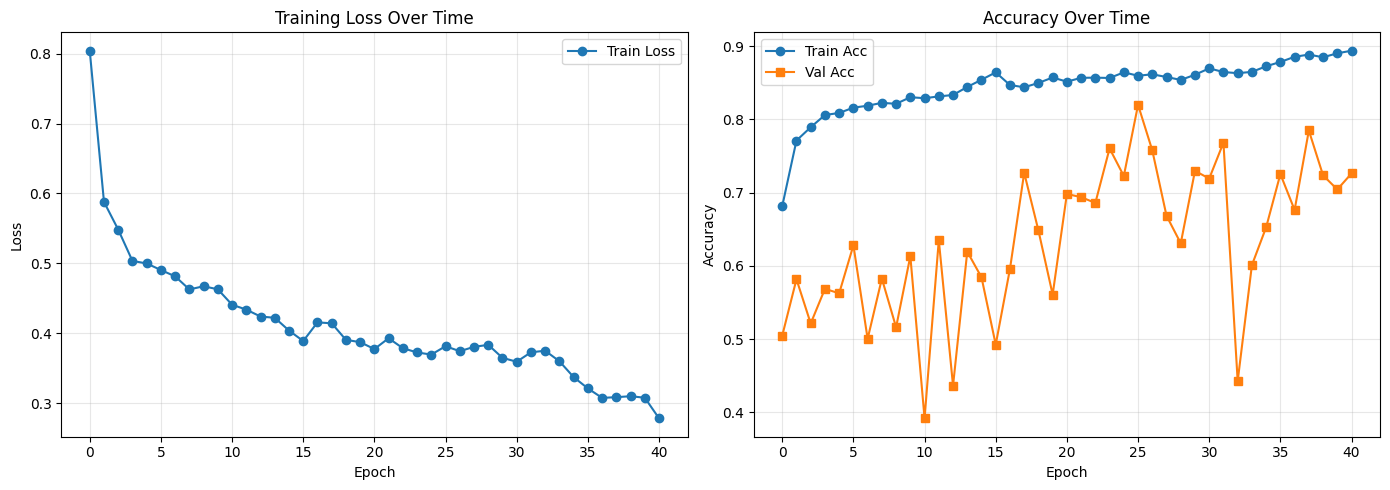

Saved: training_history.png


In [28]:
plot_training_history(history)

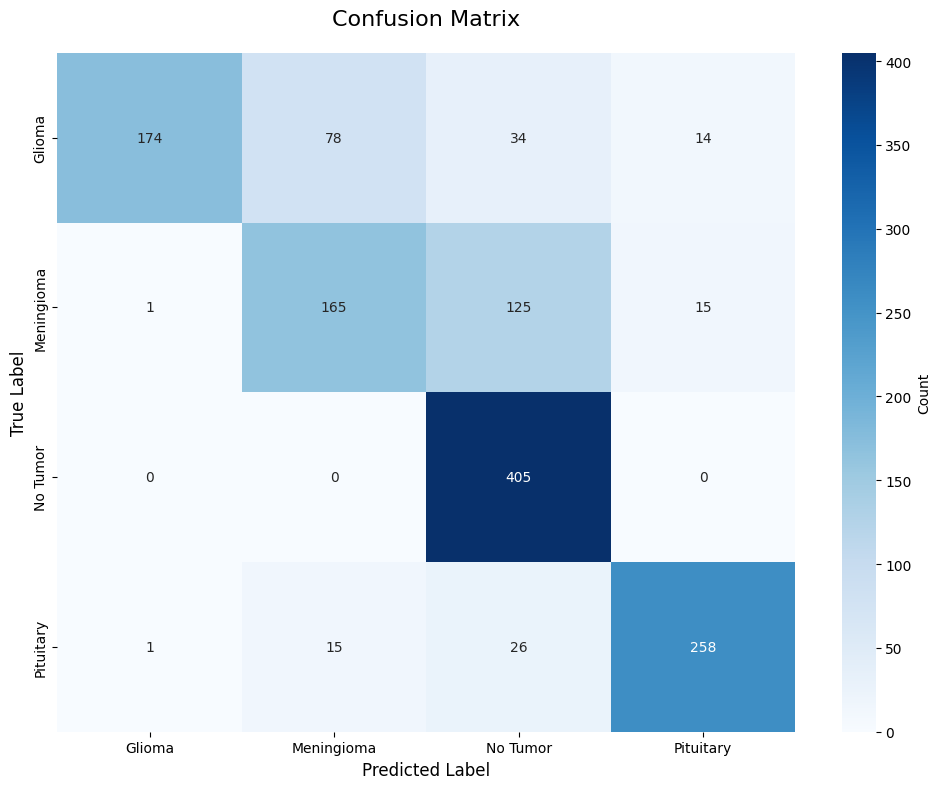

Saved: confusion_matrix.png


In [ ]:
plot_confusion_matrix(test_labels, test_preds, class_names)

In [30]:
print(f"best validation accuracy: {best_val_acc:.4f}")
print(f"final test accuracy: {test_acc:.4f}")

best validation accuracy: 0.9818
final test accuracy: 0.9643
